## Knock Out Rules optimisation through NGSA II-Pretrained Model

In [49]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  
import kooptimize.NGSAII as ngsa2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from random import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import GradientBoostingClassifier
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Pre-trained Model:
1. Split the dataset as KO Rules + CV trained model.
2. Optimise KO rule on the dataset not used for model training, using the trained model.


In [50]:
data = pd.read_csv('data/train_fin_cols.csv')

#Train on a random sub sample, as it takes time.
#data = data.sample(50000)
y_org = data['loan_default']
X_org = data.drop(['loan_default'],axis=1)

print("Loaded train data with shape {}".format(X_org.shape))
print("Loaded train target with shape {}".format(y_org.shape))

categorical_columns_to_drop = ['uniqueid','branch_id','supplier_id','manufacturer_id','current_pincode_id',
                               'state_id','employee_code_id','perform_cns_score_description','employment_type','state_hrg','emp_hrg',
                              'branch_hrg','pincode_hrg','supplier_hrg','manf_hrg']
categorical_columns = ['employment_type','perform_cns_score_description']

X_org = X_org.drop(categorical_columns_to_drop,axis=1)
#test = test.drop(categorical_columns_to_drop,axis=1)


#Split the dataset and train the model on it.

X_crm,X_optimize,y_crm,y_optimize=train_test_split(X_org,y_org,train_size=0.8,random_state=42)


individual = [1,1,1,1,1,1,1,1,1,1]
selected_rules = ngsa2.get_rules_for_individual(individual)
X_ko_crm,y_ko_crm = ngsa2.apply_rules_to_df(X_crm,y_crm,selected_rules)

print(f"Records remaining after applying KO rules {X_ko_crm.shape[0]}")

#X_train,X_test,y_train,y_test = train_test_split(X_ko,y_ko,train_size=0.9,random_state=42)

def get_trained_model(X,y):
    """
    Returns a trained model.
    """
#     clf = GradientBoostingClassifier(n_estimators=500,max_features='auto',
#                                      learning_rate=0.01,random_state=0)
    clf = GradientBoostingClassifier(max_features='auto')
    
    score = cross_validate(clf,X,y,scoring=['roc_auc'],cv=5)
    return clf.fit(X,y),(np.mean(score['test_roc_auc'])*100)

print("Training model....")

start_time = time.time()
#trained_model,base_auc = get_trained_model(X_ko_crm,y_ko_crm)

print(f"Training took {time.time()-start_time} secs")
print(f"Base AUC score {base_auc}")

Loaded train data with shape (233154, 58)
Loaded train target with shape (233154,)
Records remaining after applying KO rules 69746
Training model....
Training took 3.0994415283203125e-05 secs
Base AUC score 66.96841903309803


### When all KO rules are applied :

In [51]:
individual = [1,1,1,1,1,1,1,1,1,1]
selected_rules = ngsa2.get_rules_for_individual(individual)
X_ko,y_ko = ngsa2.apply_rules_to_df(X_optimize,y_optimize,selected_rules)
print("Application with all KO rules : {}".format(X_ko.shape[0]))

Application with all KO rules : 17528


In [52]:
import time
start_time = time.time()
feature_list = [1]*10
print("AUC with All Rules  : {} ".format(ngsa2.get_auc(X_ko,y_ko,trained_model,feature_list)))
chromosome_length = len(feature_list)
print("No.of KO Rules : {}".format(chromosome_length))
print("Time Taken : {} s".format(time.time()-start_time))

AUC with All Rules  : 66.9156338683074 
No.of KO Rules : 10
Time Taken : 0.17025303840637207 s


1.0 -1.71787043051188 20740
2.0 -1.7201460723516533 20725
2.0 -7.126132984098426 46623
1.0 -7.210716489673246 46016
2.0 -7.21189463808409 46013
4.0 -7.211108106359617 45943
5.0 -2.1167721010513674 19335
7.0 -1.0821120812430252 17529
4.0 -1.7461413369907604 20127
4.0 -7.2051468547744975 46009
5.0 -7.206765189150481 46007
7.0 -1.7393231581143027 20106
1.0 -7.127626724336871 46631
2.0 -7.124998144461884 46626
2.0 -1.71787043051188 20740
3.0 -7.216674616271895 45950
4.0 -7.130437795260107 46560
4.0 -2.099350476054852 19352
5.0 -1.7461413369907604 20127
3.0 -7.134833962251882 46543
2.0 -7.210716489673246 46016
3.0 -2.2050320930506757 18809
5.0 -2.2172738010504247 18793
4.0 -7.203381743443444 46011
6.0 -1.0701637947438059 17542
8.0 -1.0821120812430252 17529
4.0 -7.126132984098426 46623
5.0 -7.130437795260107 46560
9.0 -1.0821120812430252 17529
6.0 -1.7461413369907604 20127
8.0 -2.2053557385058866 18804
10.0 -1.0843661316926045 17528
Generation 0 out of 10 
1.0 -1.71787043051188 20740
1.0 -7.

[Text(0, 0.5, 'Time(secs)'), Text(0.5, 0, 'Generations')]

Text(0.5, 1.0, 'Time required per Generation.')

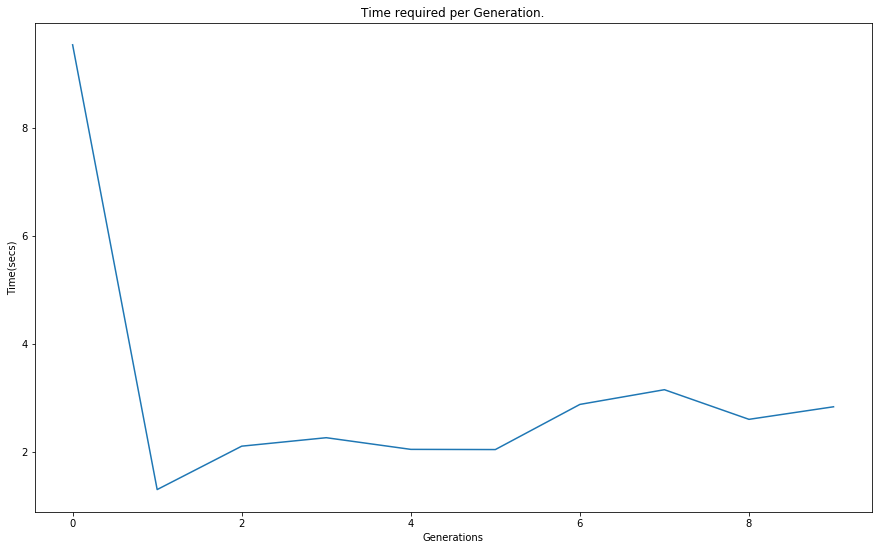

In [53]:
# Set general parameters
starting_population_size = 20
maximum_generation = 10
minimum_population_size = 5
maximum_population_size = 10

# Create starting population
population = ngsa2.create_population(starting_population_size,chromosome_length)
population = np.unique(population, axis=0)
# Now we'll go through the generations of genetic algorithm

generation_list = []
time_required = []

for generation in range(maximum_generation):
    start_time = time.time()
    
    # Breed
    population = ngsa2.breed_population(population)
    
    # Score population
    population,scores = ngsa2.score_population_with_trained_clf(X_optimize,y_optimize,
                                                                trained_model,population)
    
    # Build pareto front
    population = ngsa2.build_pareto_population(
            population, scores, minimum_population_size, maximum_population_size)
    
    if generation %10 == 0:
        print ('Generation {} out of {} '.format(generation,maximum_generation))
    #ngsa2.plot_2d_paretofront(scores,generation)
    #ngsa2.plot_3d_paretofront(scores,generation)
    
    time_taken = time.time()-start_time
    #print("{} secs for Generation {} ".format(time_taken,generation))
    
    generation_list.append(generation)
    time_required.append(time_taken)
    

# Get final pareto front
population,scores = ngsa2.score_population_with_trained_clf(X_optimize,y_optimize,
                                                            trained_model,population)
population_ids = np.arange(population.shape[0]).astype(int)
pareto_front = ngsa2.identify_pareto(scores, population_ids)
population = population[pareto_front, :]
scores = scores[pareto_front]

#Selected Population
#print("Selected Population : \n",population)
#print("Scores", scores)
#ngsa2.plot_2d_paretofront(scores,generation+1)
#ngsa2.plot_3d_paretofront(scores,generation+1)

#Plot time taken for calculation.
fig,ax = plt.subplots()
ax.plot(generation_list,time_required)
ax.set(xlabel="Generations",ylabel="Time(secs)")
ax.set_title('Time required per Generation.')
fig.show()

### Final Results

In [54]:
ngsa2.show_population_score_df(population,scores)

,AUC,No.ofApplications,Rules
0,-0.992974,18096.0,"{1.0: 'age_when_disbursal <= 840 ', 2.0: 'ltv <= 95', 6.0: 'avg_acct_age_m >= 6', 8.0: 'perform_cns_score >= 200'}"
1,-7.127627,46631.0,{2.0: 'ltv <= 95'}
2,-7.124998,46626.0,"{2.0: 'ltv <= 95', 9.0: 'pri_overdue_accts <=10'}"
3,-0.992974,18096.0,"{2.0: 'ltv <= 95', 6.0: 'avg_acct_age_m >= 6', 8.0: 'perform_cns_score >= 200'}"
4,-7.127627,46631.0,"{1.0: 'age_when_disbursal <= 840 ', 2.0: 'ltv <= 95'}"
